In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

# 数据预处理

In [3]:
train['HomePlanet'].fillna('Unknown', inplace=True)
train=train.dropna(subset=['CryoSleep']) # No rows dropped for test
train=train.dropna(subset=['Cabin']) # No rows dropped for test
train['Destination'].fillna('Unknown', inplace=True)
train['Age'].fillna(train['Age'].mean(), inplace=True)
train['VIP'].fillna(False, inplace=True)
train['RoomService'].fillna(0, inplace=True)
train['FoodCourt'].fillna(0, inplace=True)
train['ShoppingMall'].fillna(0, inplace=True)
train['Spa'].fillna(0, inplace=True)
train['VRDeck'].fillna(0, inplace=True)
train=train.drop(columns=['Name'])
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


In [4]:
# Same for test set
test['HomePlanet'].fillna('Unknown', inplace=True)
test['Destination'].fillna('Unknown', inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)
test['VIP'].fillna(False, inplace=True)
test['RoomService'].fillna(0, inplace=True)
test['FoodCourt'].fillna(0, inplace=True)
test['ShoppingMall'].fillna(0, inplace=True)
test['Spa'].fillna(0, inplace=True)
test['VRDeck'].fillna(0, inplace=True)
test=test.drop(columns=['Name'])
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,28.658146,False,0.0,0.0,0.0,0.0,0.0
4275,9273_01,Europa,False,D/297/P,Unknown,28.658146,False,0.0,2680.0,0.0,0.0,523.0


## Extracting Features "From Cabin(Deck/Num/Side)":

In [5]:
# Convert Cabin column to (Deck, Num, Side) columns
train[['Deck', 'Num','Side']] = train.Cabin.str.split("/", expand = True)
test[['Deck', 'Num','Side']] = test.Cabin.str.split("/", expand = True)

# Remove old Cabin column
train=train.drop(columns=['Cabin'])
test=test.drop(columns=['Cabin'])

One hot encoding

In [6]:
# Side we make it Side_P bolean value True if = P , False if = S
train['Side_P']=train['Side']=='P'
# Drop old Side column
train=train.drop(columns=['Side'])
# for test set
test['Side_P'] = np.where(test['Side'] == 'P', True, np.where(test['Side'] == 'S', False, np.nan))
# Drop old Side column
test=test.drop(columns=['Side'])

# Deck there are 8 categories
train=pd.get_dummies(train,columns=['Deck'])
test=pd.get_dummies(test,columns=['Deck'])

# Num should be transfered to int
train=train.astype({'Num':'int'})
# For test
test['Num'] = pd.to_numeric(test['Num'], errors='coerce').astype('Int64')

# Make one hot coding for HomePlanet, Destination
train=pd.get_dummies(train,columns=['HomePlanet','Destination'])
test=pd.get_dummies(test,columns=['HomePlanet','Destination'])

train=train.astype({'CryoSleep':'bool'})
# For test
test['CryoSleep'] = test['CryoSleep'].astype(pd.BooleanDtype())

# Check all types
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8284 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                8284 non-null   object 
 1   CryoSleep                  8284 non-null   bool   
 2   Age                        8284 non-null   float64
 3   VIP                        8284 non-null   bool   
 4   RoomService                8284 non-null   float64
 5   FoodCourt                  8284 non-null   float64
 6   ShoppingMall               8284 non-null   float64
 7   Spa                        8284 non-null   float64
 8   VRDeck                     8284 non-null   float64
 9   Transported                8284 non-null   bool   
 10  Num                        8284 non-null   int32  
 11  Side_P                     8284 non-null   bool   
 12  Deck_A                     8284 non-null   uint8  
 13  Deck_B                     8284 non-null   uint8

In [7]:
correlation_matrix=train.corr()
correlation_matrix

C:\Users\zengsong\AppData\Local\Temp\ipykernel_23604\2134942268.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=train.corr()


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,...,Deck_G,Deck_T,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_Unknown
CryoSleep,1.000000,-0.073049,-0.078675,-0.255956,-0.207876,-0.210218,-0.201112,-0.195844,0.467484,-0.037560,...,0.252820,-0.016358,-0.111814,0.096623,0.034326,0.003678,0.065120,0.092115,-0.105226,-0.026960
Age,-0.073049,1.000000,0.092853,0.070046,0.129510,0.032735,0.119642,0.100972,-0.075825,-0.132890,...,-0.214481,0.012514,-0.198702,0.219211,0.013670,-0.002344,0.016026,-0.026886,-0.001624,0.014123
VIP,-0.078675,0.092853,1.000000,0.036186,0.125637,0.017253,0.057207,0.117695,-0.035127,-0.098534,...,-0.100613,-0.003368,-0.162954,0.144452,0.047009,0.003065,0.039571,-0.001141,-0.030155,-0.011292
RoomService,-0.255956,0.070046,0.036186,1.000000,-0.016441,0.053597,0.010286,-0.023127,-0.246065,-0.007720,...,-0.152087,-0.003951,-0.140558,-0.078715,0.260390,-0.005408,-0.029741,-0.064322,0.066741,-0.003590
FoodCourt,-0.207876,0.129510,0.125637,-0.016441,1.000000,-0.012198,0.217162,0.223465,0.046758,-0.181065,...,-0.151763,0.015501,-0.208147,0.365734,-0.124057,-0.020503,0.133918,-0.064488,-0.073383,-0.009491
ShoppingMall,-0.210218,0.032735,0.017253,0.053597,-0.012198,1.000000,0.017675,-0.006914,0.012925,0.000685,...,-0.110036,-0.006190,-0.071188,-0.015041,0.107383,-0.008016,-0.010966,-0.030945,0.030342,-0.005403
Spa,-0.201112,0.119642,0.057207,0.010286,0.217162,0.017675,1.000000,0.151816,-0.216969,-0.129806,...,-0.125846,0.043495,-0.153221,0.263650,-0.086666,-0.011653,0.072875,-0.055267,-0.031847,0.009104
VRDeck,-0.195844,0.100972,0.117695,-0.023127,0.223465,-0.006914,0.151816,1.000000,-0.204975,-0.137288,...,-0.131034,0.008949,-0.154064,0.285303,-0.112748,-0.000890,0.089384,-0.046681,-0.045793,-0.009363
Transported,0.467484,-0.075825,-0.035127,-0.246065,0.046758,0.012925,-0.216969,-0.204975,1.000000,-0.045087,...,0.017763,-0.011170,-0.168624,0.175768,0.021372,0.001133,0.108337,0.004507,-0.097225,0.001313
Num,-0.037560,-0.132890,-0.098534,-0.007720,-0.181065,0.000685,-0.129806,-0.137288,-0.045087,1.000000,...,0.191702,-0.025705,0.363549,-0.489171,0.063841,0.017885,-0.141513,0.102940,0.058740,0.001165


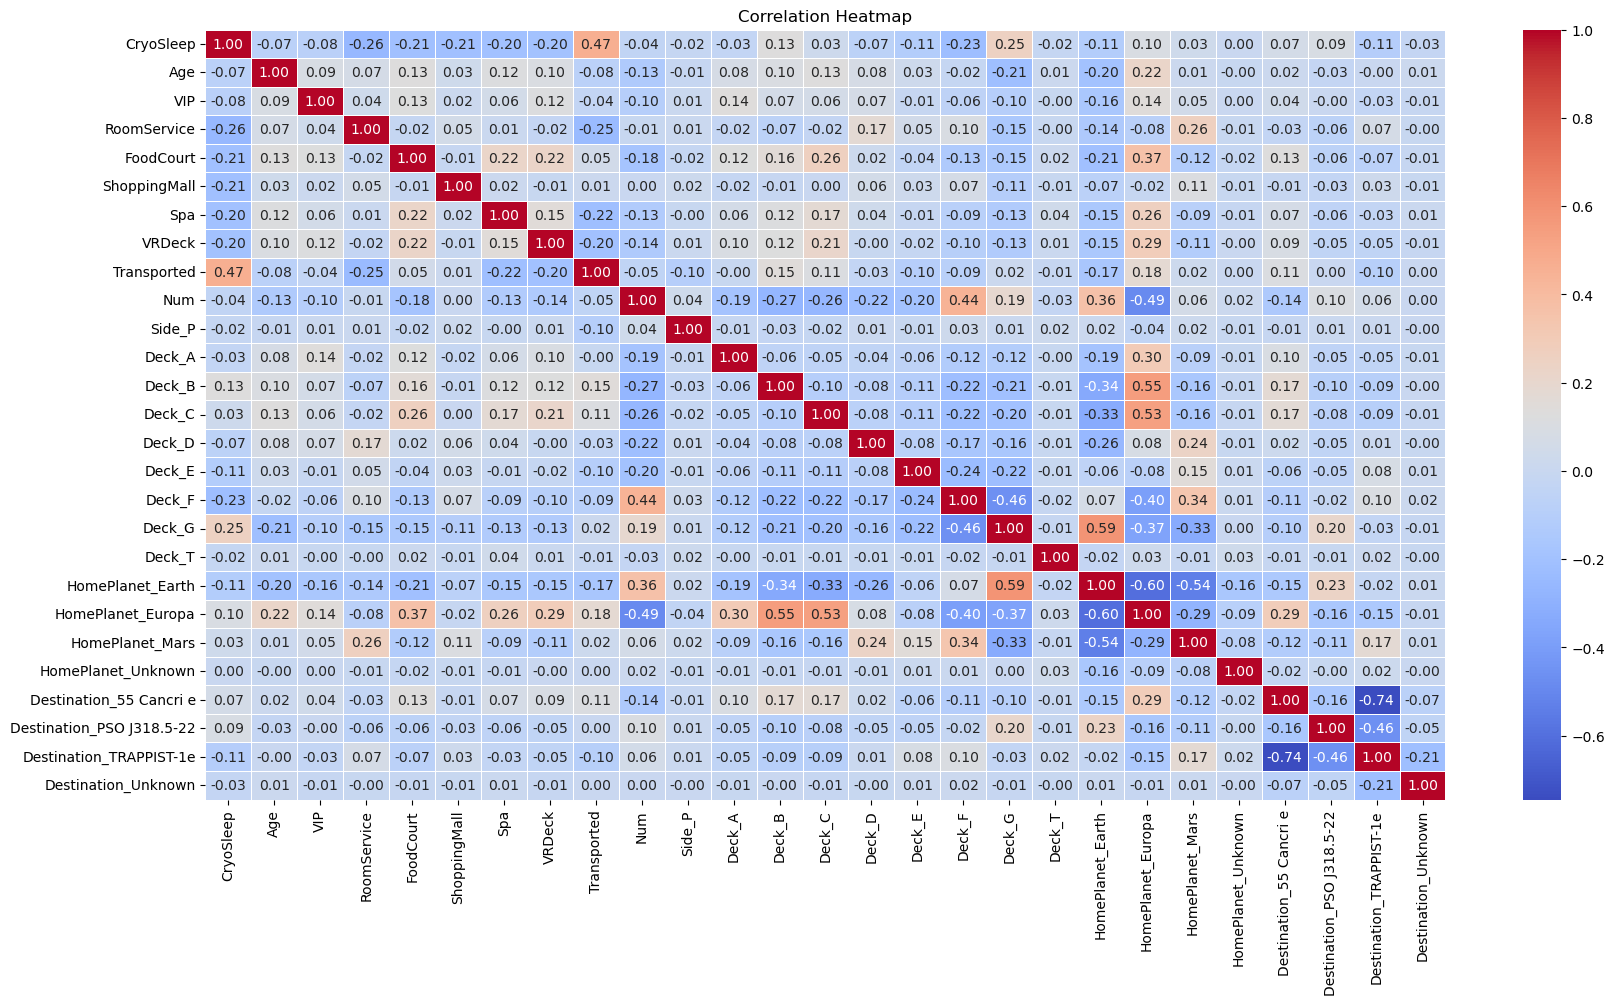

In [8]:
# Create the correlation heatmap with two decimal places in annotations
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Handle missing data for test set (without removing rows)

In [9]:
# Create a KNNImputer instance
imputer = KNNImputer(n_neighbors=10)

# Perform K-NN imputation on the column
test_imputed = imputer.fit_transform(test)
test_imputed = pd.DataFrame(test_imputed)

# Put imputed columns in test dataframe
test['CryoSleep']=test_imputed[1]
test['Num']=test_imputed[9]
test['Side_P']=test_imputed[10]

## Change all Bool to int

In [10]:
# For train dataset
columns_to_convert_to_int = ['CryoSleep', 'VIP', 'Transported', 'Side_P',
                             'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
                             'Deck_F', 'Deck_G', 'Deck_T','HomePlanet_Earth',
                            'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Unknown',
                             'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
                            'Destination_TRAPPIST-1e', 'Destination_Unknown']
train = train.astype({col: 'int' for col in columns_to_convert_to_int})

# For test dataset
columns_to_convert_to_int = ['VIP',
                             'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
                             'Deck_F', 'Deck_G', 'Deck_T','HomePlanet_Earth',
                            'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Unknown',
                             'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
                            'Destination_TRAPPIST-1e', 'Destination_Unknown']
test = test.astype({col: 'int' for col in columns_to_convert_to_int})

## Extract 

In [11]:
X = train.drop(['Transported', 'PassengerId'], axis=1)
y = train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)
X_test = test.drop(['PassengerId'], axis=1)

# Model 1 :RandomForestClassifier

In [12]:
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model1.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8074834037417019


# Model 2 :DNN

In [13]:
def PlotHistory(history,x):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot for 40 epochs loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'][x:], label='Training Loss')
    plt.plot(history.history['val_loss'][x:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss After {x} Epochs')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Build the DNN model
model2 = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model2
history = model2.fit(X_train, y_train, epochs=750, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model2 on the validation set
loss, accuracy = model2.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')



Epoch 1/750


208/208 [==============================] - 1s 2ms/step - loss: 8.2399 - accuracy: 0.6922 - val_loss: 3.9485 - val_accuracy: 0.7435
Epoch 2/750
208/208 [==============================] - 0s 978us/step - loss: 2.0773 - accuracy: 0.7417 - val_loss: 2.6357 - val_accuracy: 0.7477
Epoch 3/750
208/208 [==============================] - 0s 966us/step - loss: 2.2814 - accuracy: 0.7332 - val_loss: 2.8273 - val_accuracy: 0.6524
Epoch 4/750
208/208 [==============================] - 0s 991us/step - loss: 1.6674 - accuracy: 0.7474 - val_loss: 1.6926 - val_accuracy: 0.7689
Epoch 5/750
208/208 [==============================] - 0s 958us/step - loss: 1.5460 - accuracy: 0.7524 - val_loss: 1.8588 - val_accuracy: 0.6964
Epoch 6/750
208/208 [==============================] - 0s 974us/step - loss: 1.5077 - accuracy: 0.7482 - val_loss: 2.0720 - val_accuracy: 0.7417
Epoch 7/750
208/208 [==============================] - 0s 953us/step - loss: 1.4383 - accuracy: 0.7463 - val_loss: 1.7985 - val_

208/208 [==============================] - 0s 949us/step - loss: 0.8263 - accuracy: 0.7709 - val_loss: 1.0823 - val_accuracy: 0.7272
Epoch 51/750
208/208 [==============================] - 0s 922us/step - loss: 0.7994 - accuracy: 0.7658 - val_loss: 1.0426 - val_accuracy: 0.7049
Epoch 52/750
208/208 [==============================] - 0s 938us/step - loss: 0.7761 - accuracy: 0.7712 - val_loss: 0.9630 - val_accuracy: 0.7580
Epoch 53/750
208/208 [==============================] - 0s 927us/step - loss: 0.7840 - accuracy: 0.7635 - val_loss: 0.8273 - val_accuracy: 0.7272
Epoch 54/750
208/208 [==============================] - 0s 926us/step - loss: 0.9723 - accuracy: 0.7601 - val_loss: 0.8925 - val_accuracy: 0.7664
Epoch 55/750
208/208 [==============================] - 0s 919us/step - loss: 0.9191 - accuracy: 0.7592 - val_loss: 1.9712 - val_accuracy: 0.6270
Epoch 56/750
208/208 [==============================] - 0s 925us/step - loss: 0.9858 - accuracy: 0.7631 - val_loss: 0.8068 - val_accuracy

208/208 [==============================] - 0s 941us/step - loss: 0.5548 - accuracy: 0.7764 - val_loss: 0.5323 - val_accuracy: 0.7731
Epoch 107/750
208/208 [==============================] - 0s 936us/step - loss: 0.5502 - accuracy: 0.7788 - val_loss: 0.6180 - val_accuracy: 0.7737
Epoch 108/750
208/208 [==============================] - 0s 931us/step - loss: 0.5148 - accuracy: 0.7839 - val_loss: 0.5440 - val_accuracy: 0.7785
Epoch 109/750
208/208 [==============================] - 0s 925us/step - loss: 0.5718 - accuracy: 0.7756 - val_loss: 0.5354 - val_accuracy: 0.7737
Epoch 110/750
208/208 [==============================] - 0s 932us/step - loss: 0.5494 - accuracy: 0.7783 - val_loss: 0.5932 - val_accuracy: 0.7695
Epoch 111/750
208/208 [==============================] - 0s 919us/step - loss: 0.5336 - accuracy: 0.7794 - val_loss: 0.5263 - val_accuracy: 0.7773
Epoch 112/750
208/208 [==============================] - 0s 966us/step - loss: 0.5183 - accuracy: 0.7871 - val_loss: 0.5337 - val_ac

Epoch 162/750
208/208 [==============================] - 0s 935us/step - loss: 0.4275 - accuracy: 0.7967 - val_loss: 0.4506 - val_accuracy: 0.7864
Epoch 163/750
208/208 [==============================] - 0s 942us/step - loss: 0.4340 - accuracy: 0.8011 - val_loss: 0.4793 - val_accuracy: 0.7797
Epoch 164/750
208/208 [==============================] - 0s 930us/step - loss: 0.4386 - accuracy: 0.7933 - val_loss: 0.4654 - val_accuracy: 0.7858
Epoch 165/750
208/208 [==============================] - 0s 964us/step - loss: 0.4231 - accuracy: 0.7963 - val_loss: 0.4433 - val_accuracy: 0.7882
Epoch 166/750
208/208 [==============================] - 0s 926us/step - loss: 0.4268 - accuracy: 0.7975 - val_loss: 0.4450 - val_accuracy: 0.7918
Epoch 167/750
208/208 [==============================] - 0s 963us/step - loss: 0.4304 - accuracy: 0.7972 - val_loss: 0.4460 - val_accuracy: 0.7882
Epoch 168/750
208/208 [==============================] - 0s 969us/step - loss: 0.4257 - accuracy: 0.7975 - val_loss: 0

Epoch 218/750
208/208 [==============================] - 0s 941us/step - loss: 0.4154 - accuracy: 0.8010 - val_loss: 0.4358 - val_accuracy: 0.7918
Epoch 219/750
208/208 [==============================] - 0s 945us/step - loss: 0.4164 - accuracy: 0.8040 - val_loss: 0.4359 - val_accuracy: 0.7954
Epoch 220/750
208/208 [==============================] - 0s 942us/step - loss: 0.4159 - accuracy: 0.8014 - val_loss: 0.4248 - val_accuracy: 0.7966
Epoch 221/750
208/208 [==============================] - 0s 977us/step - loss: 0.4134 - accuracy: 0.8050 - val_loss: 0.4318 - val_accuracy: 0.7984
Epoch 222/750
208/208 [==============================] - 0s 957us/step - loss: 0.4158 - accuracy: 0.8013 - val_loss: 0.4312 - val_accuracy: 0.7960
Epoch 223/750
208/208 [==============================] - 0s 959us/step - loss: 0.4160 - accuracy: 0.7995 - val_loss: 0.4322 - val_accuracy: 0.8008
Epoch 224/750
208/208 [==============================] - 0s 939us/step - loss: 0.4199 - accuracy: 0.7976 - val_loss: 0

208/208 [==============================] - 0s 958us/step - loss: 0.4104 - accuracy: 0.8035 - val_loss: 0.4335 - val_accuracy: 0.7948
Epoch 275/750
208/208 [==============================] - 0s 962us/step - loss: 0.4115 - accuracy: 0.8035 - val_loss: 0.4358 - val_accuracy: 0.7972
Epoch 276/750
208/208 [==============================] - 0s 919us/step - loss: 0.4122 - accuracy: 0.8037 - val_loss: 0.4404 - val_accuracy: 0.7936
Epoch 277/750
208/208 [==============================] - 0s 1ms/step - loss: 0.4113 - accuracy: 0.8046 - val_loss: 0.4401 - val_accuracy: 0.7966
Epoch 278/750
208/208 [==============================] - 0s 2ms/step - loss: 0.4170 - accuracy: 0.8008 - val_loss: 0.4393 - val_accuracy: 0.7888
Epoch 279/750
208/208 [==============================] - 0s 1ms/step - loss: 0.4171 - accuracy: 0.7979 - val_loss: 0.4384 - val_accuracy: 0.7948
Epoch 280/750
208/208 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.8040 - val_loss: 0.4316 - val_accuracy: 

Epoch 330/750
208/208 [==============================] - 0s 901us/step - loss: 0.4097 - accuracy: 0.8040 - val_loss: 0.4326 - val_accuracy: 0.7978
Epoch 331/750
208/208 [==============================] - 0s 912us/step - loss: 0.4131 - accuracy: 0.8029 - val_loss: 0.4331 - val_accuracy: 0.8014
Epoch 332/750
208/208 [==============================] - 0s 907us/step - loss: 0.4126 - accuracy: 0.8059 - val_loss: 0.4302 - val_accuracy: 0.7966
Epoch 333/750
208/208 [==============================] - 0s 910us/step - loss: 0.4108 - accuracy: 0.8034 - val_loss: 0.4324 - val_accuracy: 0.8014
Epoch 334/750
208/208 [==============================] - 0s 948us/step - loss: 0.4118 - accuracy: 0.8020 - val_loss: 0.4537 - val_accuracy: 0.7906
Epoch 335/750
208/208 [==============================] - 0s 902us/step - loss: 0.4145 - accuracy: 0.8058 - val_loss: 0.4334 - val_accuracy: 0.7978
Epoch 336/750
208/208 [==============================] - 0s 913us/step - loss: 0.4110 - accuracy: 0.8028 - val_loss: 0

Epoch 386/750
208/208 [==============================] - 0s 959us/step - loss: 0.4109 - accuracy: 0.8043 - val_loss: 0.4360 - val_accuracy: 0.8008
Epoch 387/750
208/208 [==============================] - 0s 962us/step - loss: 0.4088 - accuracy: 0.8069 - val_loss: 0.4472 - val_accuracy: 0.7942
Epoch 388/750
208/208 [==============================] - 0s 958us/step - loss: 0.4115 - accuracy: 0.8041 - val_loss: 0.4317 - val_accuracy: 0.8008
Epoch 389/750
208/208 [==============================] - 0s 928us/step - loss: 0.4139 - accuracy: 0.8041 - val_loss: 0.4490 - val_accuracy: 0.7948
Epoch 390/750
208/208 [==============================] - 0s 922us/step - loss: 0.4116 - accuracy: 0.8061 - val_loss: 0.4357 - val_accuracy: 0.7972
Epoch 391/750
208/208 [==============================] - 0s 905us/step - loss: 0.4093 - accuracy: 0.8043 - val_loss: 0.4447 - val_accuracy: 0.7918
Epoch 392/750
208/208 [==============================] - 0s 912us/step - loss: 0.4133 - accuracy: 0.8007 - val_loss: 0

Epoch 442/750
208/208 [==============================] - 0s 914us/step - loss: 0.4161 - accuracy: 0.8035 - val_loss: 0.4388 - val_accuracy: 0.7912
Epoch 443/750
208/208 [==============================] - 0s 924us/step - loss: 0.4136 - accuracy: 0.8029 - val_loss: 0.4353 - val_accuracy: 0.7960
Epoch 444/750
208/208 [==============================] - 0s 924us/step - loss: 0.4095 - accuracy: 0.8034 - val_loss: 0.4447 - val_accuracy: 0.7960
Epoch 445/750
208/208 [==============================] - 0s 924us/step - loss: 0.4138 - accuracy: 0.8014 - val_loss: 0.4395 - val_accuracy: 0.7966
Epoch 446/750
208/208 [==============================] - 0s 905us/step - loss: 0.4083 - accuracy: 0.8037 - val_loss: 0.4376 - val_accuracy: 0.7888
Epoch 447/750
208/208 [==============================] - 0s 893us/step - loss: 0.4094 - accuracy: 0.8026 - val_loss: 0.4380 - val_accuracy: 0.7996
Epoch 448/750
208/208 [==============================] - 0s 903us/step - loss: 0.4092 - accuracy: 0.8053 - val_loss: 0

Epoch 498/750
208/208 [==============================] - 0s 914us/step - loss: 0.4091 - accuracy: 0.8011 - val_loss: 0.4377 - val_accuracy: 0.8008
Epoch 499/750
208/208 [==============================] - 0s 921us/step - loss: 0.4342 - accuracy: 0.8061 - val_loss: 0.4573 - val_accuracy: 0.8002
Epoch 500/750
208/208 [==============================] - 0s 975us/step - loss: 0.4166 - accuracy: 0.7992 - val_loss: 0.4434 - val_accuracy: 0.7900
Epoch 501/750
208/208 [==============================] - 0s 901us/step - loss: 0.4111 - accuracy: 0.8034 - val_loss: 0.4337 - val_accuracy: 0.7978
Epoch 502/750
208/208 [==============================] - 0s 893us/step - loss: 0.4111 - accuracy: 0.7996 - val_loss: 0.4645 - val_accuracy: 0.7924
Epoch 503/750
208/208 [==============================] - 0s 935us/step - loss: 0.4068 - accuracy: 0.8034 - val_loss: 0.4411 - val_accuracy: 0.7978
Epoch 504/750
208/208 [==============================] - 0s 1ms/step - loss: 0.4120 - accuracy: 0.8037 - val_loss: 0.4

Epoch 554/750
208/208 [==============================] - 0s 957us/step - loss: 0.4081 - accuracy: 0.8082 - val_loss: 0.4449 - val_accuracy: 0.7936
Epoch 555/750
208/208 [==============================] - 0s 962us/step - loss: 0.4111 - accuracy: 0.8053 - val_loss: 0.4559 - val_accuracy: 0.7918
Epoch 556/750
208/208 [==============================] - 0s 957us/step - loss: 0.4153 - accuracy: 0.8022 - val_loss: 0.4424 - val_accuracy: 0.7936
Epoch 557/750
208/208 [==============================] - 0s 975us/step - loss: 0.4116 - accuracy: 0.8047 - val_loss: 0.4350 - val_accuracy: 0.7954
Epoch 558/750
208/208 [==============================] - 0s 980us/step - loss: 0.4068 - accuracy: 0.8046 - val_loss: 0.4359 - val_accuracy: 0.7978
Epoch 559/750
208/208 [==============================] - 0s 915us/step - loss: 0.4122 - accuracy: 0.8014 - val_loss: 0.4342 - val_accuracy: 0.7960
Epoch 560/750
208/208 [==============================] - 0s 950us/step - loss: 0.4111 - accuracy: 0.8037 - val_loss: 0

Epoch 610/750
208/208 [==============================] - 0s 930us/step - loss: 0.4101 - accuracy: 0.8032 - val_loss: 0.4335 - val_accuracy: 0.8002
Epoch 611/750
208/208 [==============================] - 0s 924us/step - loss: 0.4117 - accuracy: 0.8010 - val_loss: 0.4374 - val_accuracy: 0.8039
Epoch 612/750
208/208 [==============================] - 0s 919us/step - loss: 0.4279 - accuracy: 0.8052 - val_loss: 0.4388 - val_accuracy: 0.8002
Epoch 613/750
208/208 [==============================] - 0s 919us/step - loss: 0.4066 - accuracy: 0.8065 - val_loss: 0.4347 - val_accuracy: 0.7990
Epoch 614/750
208/208 [==============================] - 0s 932us/step - loss: 0.4082 - accuracy: 0.8017 - val_loss: 0.4340 - val_accuracy: 0.7966
Epoch 615/750
208/208 [==============================] - 0s 921us/step - loss: 0.4081 - accuracy: 0.8053 - val_loss: 0.4337 - val_accuracy: 0.8021
Epoch 616/750
208/208 [==============================] - 0s 919us/step - loss: 0.4113 - accuracy: 0.8040 - val_loss: 0

Epoch 666/750
208/208 [==============================] - 0s 906us/step - loss: 0.4103 - accuracy: 0.8019 - val_loss: 0.4379 - val_accuracy: 0.7942
Epoch 667/750
208/208 [==============================] - 0s 906us/step - loss: 0.4082 - accuracy: 0.8047 - val_loss: 0.4377 - val_accuracy: 0.7996
Epoch 668/750
208/208 [==============================] - 0s 898us/step - loss: 0.4059 - accuracy: 0.8040 - val_loss: 0.4420 - val_accuracy: 0.7966
Epoch 669/750
208/208 [==============================] - 0s 951us/step - loss: 0.4116 - accuracy: 0.8037 - val_loss: 0.4492 - val_accuracy: 0.7900
Epoch 670/750
208/208 [==============================] - 0s 919us/step - loss: 0.4077 - accuracy: 0.8038 - val_loss: 0.4356 - val_accuracy: 0.7978
Epoch 671/750
208/208 [==============================] - 0s 913us/step - loss: 0.4065 - accuracy: 0.8055 - val_loss: 0.4413 - val_accuracy: 0.7972
Epoch 672/750
208/208 [==============================] - 0s 890us/step - loss: 0.4110 - accuracy: 0.8025 - val_loss: 0

Epoch 722/750
208/208 [==============================] - 0s 888us/step - loss: 0.4057 - accuracy: 0.8059 - val_loss: 0.4401 - val_accuracy: 0.8002
Epoch 723/750
208/208 [==============================] - 0s 951us/step - loss: 0.4080 - accuracy: 0.8046 - val_loss: 0.4464 - val_accuracy: 0.7942
Epoch 724/750
208/208 [==============================] - 0s 924us/step - loss: 0.4117 - accuracy: 0.8029 - val_loss: 0.4558 - val_accuracy: 0.7936
Epoch 725/750
208/208 [==============================] - 0s 955us/step - loss: 0.4110 - accuracy: 0.8035 - val_loss: 0.4688 - val_accuracy: 0.7930
Epoch 726/750
208/208 [==============================] - 0s 1ms/step - loss: 0.4143 - accuracy: 0.8026 - val_loss: 0.4443 - val_accuracy: 0.7954
Epoch 727/750
208/208 [==============================] - 0s 1ms/step - loss: 0.4165 - accuracy: 0.8038 - val_loss: 0.4409 - val_accuracy: 0.8002
Epoch 728/750
208/208 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8044 - val_loss: 0.4405 

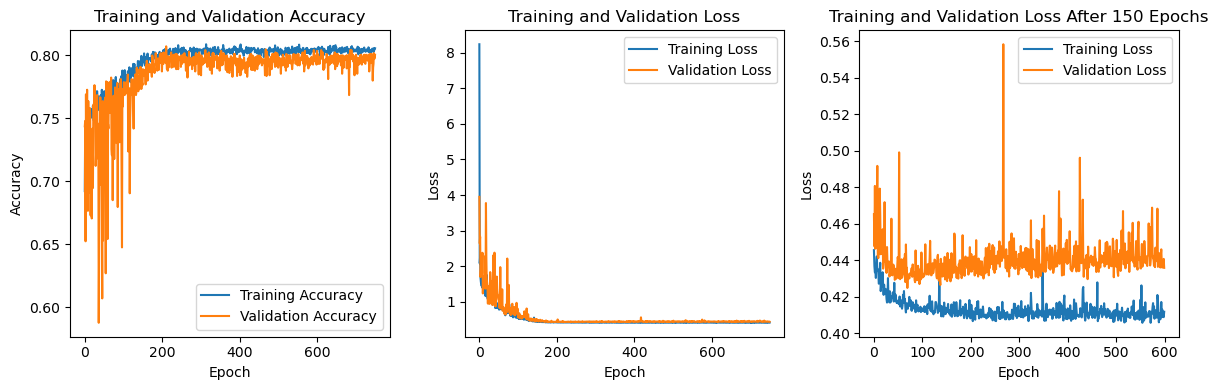

In [15]:
PlotHistory(history,150)

# Model 3 :LogisticRegression

In [16]:
# Create a Logistic Regression model3
model3 = LogisticRegression(random_state=42)

# Train the model3 on the training data
model3.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model3.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.7773083886541944
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       851
           1       0.76      0.79      0.78       806

    accuracy                           0.78      1657
   macro avg       0.78      0.78      0.78      1657
weighted avg       0.78      0.78      0.78      1657

Confusion Matrix:
[[651 200]
 [169 637]]


C:\Users\zengsong\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model 4 :xgboost

In [17]:
# Create an XGBoost classifier
model4 = xgb.XGBClassifier(random_state=100)

# Train the model4 on the training data
model4.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model4.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.8080869040434521
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       851
           1       0.80      0.80      0.80       806

    accuracy                           0.81      1657
   macro avg       0.81      0.81      0.81      1657
weighted avg       0.81      0.81      0.81      1657

Confusion Matrix:
[[694 157]
 [161 645]]


# Model 5 :lightgbm

In [18]:
# Create a LightGBM classifier
model5 = lgb.LGBMClassifier(random_state=42)

# Train the model5 on the training data
model5.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model5.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3370, number of negative: 3257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 6627, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508526 -> initscore=0.034106
[LightGBM] [Info] Start training from score 0.034106
Accuracy: 0.8092939046469523
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       851
           1       0.80      0.80      0.80       806

    accuracy                           0.81      1657
   macro avg       0.81      0.81      0.81      1657
weighted avg       0.81      0.81      0.81

# Model 6 :CatBoostClassifier

In [19]:
# Create a CatBoost classifier
model6 = CatBoostClassifier(random_state=42, verbose=0)

# Train the model6 on the training data
model6.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model6.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.8086904043452021
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       851
           1       0.79      0.82      0.81       806

    accuracy                           0.81      1657
   macro avg       0.81      0.81      0.81      1657
weighted avg       0.81      0.81      0.81      1657

Confusion Matrix:
[[677 174]
 [143 663]]


# Model 7 :AdaBoost

In [20]:
# Create a Decision Tree classifier (weak learner)
base_model = DecisionTreeClassifier(max_depth=2)  # You can adjust the 'max_depth' parameter for the weak learner

# Create an AdaBoost classifier
model7 = AdaBoostClassifier(base_model, n_estimators=80, random_state=42)  # You can adjust the 'n_estimators' parameter

# Train the model7 on the training data
model7.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model7.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

C:\Users\zengsong\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8020519010259505
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       851
           1       0.79      0.81      0.80       806

    accuracy                           0.80      1657
   macro avg       0.80      0.80      0.80      1657
weighted avg       0.80      0.80      0.80      1657

Confusion Matrix:
[[676 175]
 [153 653]]


# Model 8 :KNN

In [21]:
"""
# Create a KNN classifier
model8 = KNeighborsClassifier(n_neighbors=5)  # You can adjust the 'n_neighbors' parameter

# Train the model8 on the training data
model8.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model8.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
"""

'\n# Create a KNN classifier\nmodel8 = KNeighborsClassifier(n_neighbors=5)  # You can adjust the \'n_neighbors\' parameter\n\n# Train the model8 on the training data\nmodel8.fit(X_train, y_train)\n\n# Make predictions on the validation data\ny_pred = model8.predict(X_val)\n\n# Calculate accuracy\naccuracy = accuracy_score(y_val, y_pred)\nprint(f"Accuracy: {accuracy}")\n\n# Print classification report and confusion matrix for more detailed evaluation\nprint("Classification Report:")\nprint(classification_report(y_val, y_pred))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_val, y_pred))\n'

# Model 9 :DecisionTreeClassifier

In [22]:
# Create a Decision Tree classifier
model9 = DecisionTreeClassifier(random_state=42, max_depth=None)  # You can adjust the 'max_depth' parameter to control tree depth

# Train the model9 on the training data
model9.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = model9.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.7537718768859385
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       851
           1       0.74      0.75      0.75       806

    accuracy                           0.75      1657
   macro avg       0.75      0.75      0.75      1657
weighted avg       0.75      0.75      0.75      1657

Confusion Matrix:
[[642 209]
 [199 607]]


# Model 10 :SVM

In [23]:
# Create an SVM classifier
model10 = SVC(kernel='rbf', random_state=42, tol=1e-3)

# Train the model10 on the training data
model10.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_svm = model10.predict(X_val)

# Calculate accuracy
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")

# Print classification report and confusion matrix for more detailed evaluation
print("SVM Classification Report:")
print(classification_report(y_val, y_pred_svm))

print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_svm))

SVM Accuracy: 0.7767048883524442
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       851
           1       0.73      0.87      0.79       806

    accuracy                           0.78      1657
   macro avg       0.79      0.78      0.78      1657
weighted avg       0.79      0.78      0.78      1657

SVM Confusion Matrix:
[[586 265]
 [105 701]]


# Ensemble

In [24]:
# Make predictions using your base models
predictions_model1 = model1.predict(X_val)
predictions_model2 = model2.predict(X_val)
predictions_model4 = model4.predict(X_val)
predictions_model5 = model5.predict(X_val)
predictions_model6 = model6.predict(X_val)
predictions_model7 = model7.predict(X_val)

# Reshape the DNN output since its (1657,1) not (1657,)
predictions_model2=predictions_model2.reshape(1657,)

# Assign weights to your base models (you can adjust these weights) 0.81593
# weight_model1 = 0.2
# weight_model2 = 0.1
# weight_model4 = 0.15
# weight_model5 = 0.15
# weight_model6 = 0.2
# weight_model7 = 0.2

weight_model1 = 0.17
weight_model2 = 0.15
weight_model4 = 0.17
weight_model5 = 0.17
weight_model6 = 0.17
weight_model7 = 0.17

# Combine predictions with weighted average
final_predictions = (
    weight_model1 * predictions_model1 +
    weight_model2 * predictions_model2 +
    weight_model4 * predictions_model4 +
    weight_model5 * predictions_model5 +
    weight_model6 * predictions_model6 +
    weight_model7 * predictions_model7
)

# Round the final predictions to binary values (0 or 1)
final_predictions = np.where(final_predictions >= 0.5, 1, 0)

# Calculate accuracy
accuracy = accuracy_score(y_val, final_predictions)
print(f"Accuracy: {accuracy}")

# Print classification report and confusion matrix for more detailed evaluation
print("Classification Report:")
print(classification_report(y_val, final_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_val, final_predictions))

52/52 [==============================] - 0s 591us/step
Accuracy: 0.8147254073627037
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       851
           1       0.81      0.81      0.81       806

    accuracy                           0.81      1657
   macro avg       0.81      0.81      0.81      1657
weighted avg       0.81      0.81      0.81      1657

Confusion Matrix:
[[695 156]
 [151 655]]


In [25]:
# Make predictions using your base models
predictions_model1 = model1.predict(X_test)
predictions_model2 = model2.predict(X_test)
predictions_model4 = model4.predict(X_test)
predictions_model5 = model5.predict(X_test)
predictions_model6 = model6.predict(X_test)
predictions_model7 = model7.predict(X_test)

# Reshape the DNN output since its (4277,1) not (4277,)
predictions_model2=predictions_model2.reshape(4277,)

weight_model1 = 0.17
weight_model2 = 0.15
weight_model4 = 0.17
weight_model5 = 0.17
weight_model6 = 0.17
weight_model7 = 0.17

# Combine predictions with weighted average
final_predictions = (
    weight_model1 * predictions_model1 +
    weight_model2 * predictions_model2 +
    weight_model4 * predictions_model4 +
    weight_model5 * predictions_model5 +
    weight_model6 * predictions_model6 +
    weight_model7 * predictions_model7
)

# Round the final predictions to binary values (0 or 1)
y_result = np.where(final_predictions >= 0.5, 1, 0)
y_result = y_result.astype(bool)
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': y_result})

134/134 [==============================] - 0s 520us/step


In [26]:
result.to_csv('output/submission_sec.csv',index=False)